# Statistics exercise with an Exponential + Gaussian model


This notebook goes through various frequentist/bayesian calculations used in HEP for a simple model with an exponential background and Gaussian signal. 
$f(x|\mu; \bar{\mu}, \sigma, \lambda) = \mu * Norm(\bar{\mu}, \sigma) + (1-\mu) * Exp(1/\lambda)$

In [556]:
# Import libraries
import numpy as np
import numpy.random
import scipy.stats as st
import matplotlib.pyplot as plt

## 1. Generative model

In [557]:
# Set-up
n = 100
np.random.seed(42)

# Signal and background weights
sig_weight = 0.05
weights = [sig_weight, 1 - sig_weight]

# Params for the Exponential background
exp_lambda = 1
exp_scale = 1 / exp_lambda # typical parametrization
# Params for the Gaussian signal
norm_loc = 2 # mean
norm_scale = 0.2 # scale the width

# Distributions
gaus = st.norm(norm_loc, norm_scale) #signal
exp = st.expon(scale = exp_scale) # background
dists = [gaus, exp]

In [558]:
def sample_data(n_points, dists = dists, weights = weights):

    # A stream of indices from which to choose the component
    mixture_idx = np.random.choice(2, size=n_points, replace=True, p=weights)

    # Mixture sample
    return np.array([dists[i].rvs() for i in mixture_idx])

data = sample_data(n)

In [559]:
# Theoretical PDF plotting -- generate the x and y plotting positions
xs = np.linspace(data.min(), data.max(), 200)
s_b = np.zeros_like(xs)
b = np.zeros_like(xs)

# Signal + Bkg PDF
for d, w in zip(dists, weights):
    s_b += d.pdf(xs) * w 

# Background only PDF:
b += weights[1] * dists[1].pdf(xs)

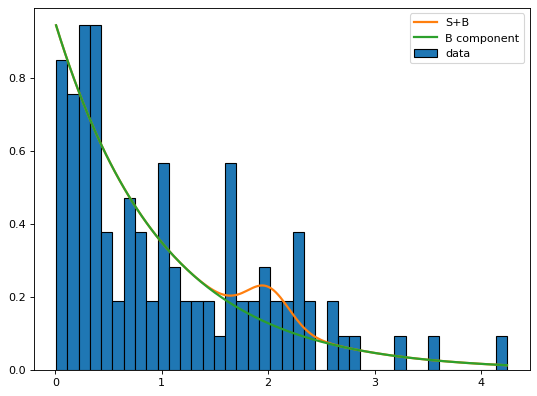

In [560]:
# Plot the data and the PDF
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.hist(data, bins=40, density=True, edgecolor='k', label='data')
plt.plot(xs, s_b, linewidth=2, label='S+B')
plt.plot(xs, b, linewidth=2, label='B component')
plt.legend(loc='upper right')

chi2 = (x-mu)^2/sigma^2 
Relationship between chi-squared and likelihood
Chi-squared × 1⁄2 is lnL for Gaussian distributed variables
Maximum probability corresponds to minimum chi-squared
For Gaussian distributed variables: fitting # minimising chi-squared
 In general, the fitted minimum chi-squared is distributed as chi-squared for (number of measurements – number of fitted parameters) degrees of freedom
 
 chi2 = -2 lnL + kappa
 can add a constant withouth changing

## 2. Frequentist analysis

### 2.1 Maximum Likelihood Estimate

We set up the log-likelihood and calculate the minimum of the function with the scipy optimization package. 

In [561]:
def log_likelihood(sig_frac, x):

    sig_weight = sig_frac
    bkg_weight = 1 - sig_weight

    ll = st.norm(norm_loc, norm_scale).pdf(x) * sig_weight + st.expon(scale = exp_scale).pdf(x) * bkg_weight

    return np.log(ll).sum()

In [562]:
import scipy.optimize as opt

nll = lambda *args: -log_likelihood(*args)

sig_frac_init = 0.5
params_init = np.array([sig_frac_init])
mle_args = (data)
result = opt.minimize(nll, params_init, args=(mle_args), bounds=((0., 1.),))
print(result)

      fun: 103.21634733131589
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.42108547e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 8
   status: 0
  success: True
        x: array([0.09336749])


In [563]:
# Print the maximum likelihood estimate and the uncertainty
mle_sig = result.x[0]
vcv_mle = result.hess_inv
sigma_sig = np.sqrt(vcv_mle.todense())
print( "The MLE is:", mle_sig, "+-", sigma_sig[0][0])

The MLE is: 0.09336748996683218 +- 0.04590945195497848


We scan the likelihood to inspect the behaviour

In [260]:
# Scan the negative log likelihood
def scan_nll(data, x_range = [0.0,0.5], points = 1000):

    sig_frac_vals = np.linspace(x_range[0], x_range[1], points)
    nll_val = []
    for i, sig in enumerate(sig_frac_vals):
        nll_val.append( -1*log_likelihood(sig, data) )
    return sig_frac_vals, np.array(nll_val)

x_scan, y_scan = scan_nll(data, x_range = [0.0,0.1], points = 1000)

In [261]:
gaus = -1*np.log(st.norm(loc=mle_sig, scale=sigma_sig).pdf(x_scan)[0])

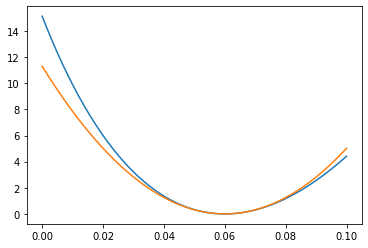

In [262]:
plt.plot(x_scan, y_scan-np.min(y_scan))
plt.plot(x_scan, gaus-min(gaus) )
plt.show()

### 2.2 Hypothesis tests with toys

In [1193]:
from scipy.special import erf, erfinv



def Z_to_p(Z):
    #pvalue = 0.5 * (1+erf(Z/np.sqrt(2.0)))
    pvalue = erf(Z / np.sqrt(2.))
    return pvalue

def Z_alpha(alpha):
    pvalue = 0.5 * (1+erf(alpha/np.sqrt(2.0)))
    return pvalue

def alpha_to_Z(alpha):
    Z = np.sqrt(2.) * erfinv(1. - alpha)
    return Z

def p_est(q):
    return 0.5*(1-erf(np.sqrt(q)/np.sqrt(2.)))

def chi2_cut(alpha):
    return st.chi2(1).ppf(0.955)

In [1185]:
p_est(2)

0.07864960352514261

In [1196]:
Z_alpha(2)

0.9772498680518208

In [1191]:
chi2_cut(0.)

4.018639511074698

In [1181]:
twosig = Z_to_p(2)

In [1182]:
p_twosig = 1-twosig

In [1183]:
p

0.04550026389635842

In [1184]:
alpha_to_Z(p)

2.0000000000000004

Given two hypothesis $H_b$ and $H_{s+b}$, the Likelihood Ratio can be used as a test statistic: $\lambda(x) = \frac{L(x|H_{s+b})}{L(x|H_b)}$. The frequentist solution to calculate P(data|theory) is to order all observed data samples with a LR test statistic. The probability to observe "similar data or more extreme" then amounts to calculating the probability to observe test statistic $\lambda(x)$ as large or larger than the observed test statistic $\lambda(x_{obs})$. The distribution of a test statistic is generally not known, therefore one has to generate toy MC to approximate the distributions. Thus we generate $N$ toy datasets under $H_b$ and $H_{s+b}$ and evaluate $\lambda(N)$ for each dataset:

In [263]:
def toy(sig_hypo, sig_frac=sig_weight, n_evts=n):
    
    sig_weight = sig_hypo
    bkg_weight = 1. - sig_hypo
    
    # Generate dataset
    toy_data = sample_data(n_evts, weights=[sig_weight, bkg_weight])
    # Calculate lambda for H0 and H1
    ll_b = log_likelihood( 0, toy_data)
    ll_sb = log_likelihood( sig_frac, toy_data)
    return (ll_sb,ll_b)
    

In [264]:
# Generate toys and evaluate the LR
n_toys = 1000
lambda_b = []
lambda_sb = []
for i in range(n_toys):
    lambda_b.append(toy(0.))
    lambda_sb.append(toy(sig_weight))

In [273]:
delta_ll_b = np.array([x[0] - x[1] for x in lambda_b]) * -1
delta_ll_sb = np.array([x[0] - x[1] for x in lambda_sb]) * -1

In [275]:
# Evaluate the observed LR on the data:
ll_b_obs = log_likelihood( 0, data)
ll_sb_obs = log_likelihood( sig_weight, data)
LR_obs = np.array(ll_sb_obs - ll_b_obs)*-1

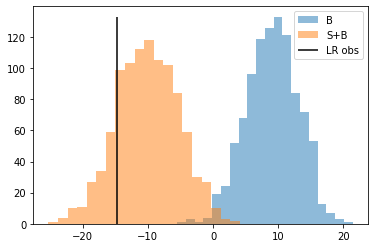

In [288]:
# Plot the distributions
n_b, _, _ = plt.hist(delta_ll_b, bins=20, alpha=0.5, label='B')
n_sb, _, _ = plt.hist(delta_ll_sb, bins=20, alpha=0.5, label='S+B')
plt.vlines(LR_obs, 0, max(max(n_b), max(n_sb)), label='LR obs')
plt.legend(loc='upper right')

In [278]:
# Fractions of toys at the LR cut
frac_b = delta_ll_b[delta_ll_b < LR_obs]
frac_sb = delta_ll_sb[delta_ll_sb > LR_obs]

In [279]:
p_b = len(frac_b) / len(lambda_b)
p_sb = len(frac_sb) / len(lambda_sb)

In [281]:
print("The p-value for the background only hypothesis is:", p_b)
print("The p-value for the signal + background hypothesis is:", p_sb)

The p-value for the background only hypothesis is: 0.0
The p-value for the signal + background hypothesis is: 0.845


CLS procedure: The CLs solution is to base the test not on the usual p-value (CLs+b), but rather to divide this by CLb (~ one minus the p-value of the b-only hypothesis). The s+b hypothesis is rejected if: $Cls < \alpha$. This
increases the effective” p-value when the two distributions become close (prevents exclusion if sensitivity is low).

In [282]:
Cls = p_sb / 1-p_b
print("The Cls value is:", Cls)

The Cls value is: 0.845


### 2.3 Hypothesis tests in the asymptotic limit

To test the background only hypothesis we can make use of Wilks theorem: the distribution of the test statistics $t_{0} = -2 \ln\frac{L(data|\mu=0)}{L(data|\hat{\mu})}$ with $p$ parameters is asymptotically distributed as a $\chi^2(p)$ with $p$ degrees of freedom. The value of the $\chi^2(p)$ has the following interpretation. The area under the $\chi^2(p)$ pdf from LR and above is the significance level or p-value. It represents the probability that the null hypothesis $\mu=0$ is true given the MLE estimate $\hat{\mu}$. More precisely, it represents the probability of null hypotheses with LR test statistics greater than or equal to (worse) the LR statistic from the null hypotheses $\mu=0$. When this p-value is small, it is highly unlikely that the null hypothesis is true. The $\chi^2(p)$ significance level can be calculated by taking one minus the cumulative distribution function (cdf) of $\chi^2(p)$ at the LR value.

In [301]:
def LR_asymptotic(mu, mle, data, dof = 1):
    ll_mu = log_likelihood(mu, data)
    ll_mle = log_likelihood(mle, data)
    LR = -1 * 2 * (ll_mu - ll_mle)
    p_value = 1.0 - st.chi2.cdf(LR, dof)
    return LR, p_value

In [302]:
# Test B only hypothesis
LR_b, p_value_b = LR_asymptotic(0., mle_sig, data, dof = 1)
print('chi squared of b only with 1 degrees of freedom p-value = ', p_value_b)

chi squared of b only with 1 degrees of freedom p-value =  3.786829383400914e-08


In [304]:
# Test SB hypothesis
LR_sb, p_value_sb = LR_asymptotic(sig_weight, mle_sig, data, dof = 1)
print('chi squared of SB with 1 degrees of freedom p-value = ', p_value_sb)

chi squared of SB with 1 degrees of freedom p-value =  0.41816016682880985


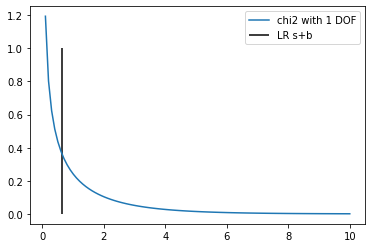

In [317]:
# Plot of chi2 with 1 degree of freedom
x_chi2 = np.linspace(0, 10, 100)
y_chi2 = st.chi2(1).pdf(x_chi2)
plt.plot(x_chi2,y_chi2, label='chi2 with 1 DOF')
#plt.vlines(LR_b, 0, 1, label='LR b')
plt.vlines(LR_sb, 0, 1, label='LR s+b')
plt.legend(loc='upper right')
#plt.yscale('log')
plt.show()

### 2.4 Central confidence intervals

An interval on $\mu$ at X% confidence level is defined such that the true of value of $\mu$ is contained X% of the time in the interval. Given the likelihood ratio $t_{\mu} = -2 \ln\frac{L(data|\mu)}{L(data|\hat{\mu})}$, Wilks theorem states that the asymptotic form of $f(t_{\mu}|\mu)$ is a $\chi^2$ distribution: $f(t_{\mu}|\mu) = \chi^2(t_{\mu},p)$ with $p$ the number of parameters. Thus in the asymptotic limit $f(t_{\mu}|\mu)$ is independent of $\mu$ and the Neyman belt is a box. The constructed confidence interval can be simplified to finding the range in $\mu$ where $t_{\mu}=\frac{1}{2}⋅Z^2$. This corresponds to the MINOS error. The Neyman constructions guarantees coverage. In the limit of normal distributions the likelihood becomes exactly parabolic and the ML Variance estimate converges to the Likelihood Ratio interval.


In [528]:
# Scan the likelihood
x_range = [0.0,0.5]
x_scan, y_scan = scan_nll(data, x_range = x_range, points = 10000)

In [1095]:
def calc_interval(x_scan, y_scan, Z=2):

    y_lim = 0.5*Z*Z
    y_vals = y_scan-np.min(y_scan)
    x_min =  np.where(y_vals == np.amin(y_vals))[0][0]

    upper_idx = x_min
    while y_vals[upper_idx] <= y_lim:
        upper_idx += 1
    
    lower_idx = x_min
    while y_vals[lower_idx] <= y_lim:
        lower_idx -= 1    

    return x_scan[lower_idx], x_scan[upper_idx]

lim_low, lim_up = calc_interval(x_scan, y_scan)

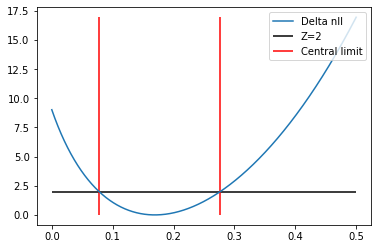

In [535]:
delta_nll = y_scan-np.min(y_scan)
plt.plot(x_scan, delta_nll, label="Delta nll")
plt.hlines(2, x_range[0], x_range[1], label = "Z=2")
plt.vlines(lim_low, 0, max(delta_nll), colors='r', label="Central limit")
plt.vlines(lim_up, 0, max(delta_nll), colors='r')
plt.legend(loc='upper right')

In [543]:
print("The Z=2 confidence interval on mu is: [", round(lim_low, 4), round(lim_up, 4), "]" )
print("The Z=2 interval with the mle uncertainty is: [", round(mle_sig-2*sigma_sig[0][0], 4), 
      round(mle_sig+2*sigma_sig[0][0], 4), "]")

The Z=2 confidence interval on mu is: [ 0.0777 0.2767 ]
The Z=2 interval with the mle uncertainty is: [ 0.0687 0.2698 ]


#### Coverage

A confidence interval is an interval on a parameter that contains the true value X% of the time. Each future measurement will result a confidence interval that has somewhat different limits every time"
(‘confidence interval limits are a random variable’)! But procedure is constructed such that true value is in X% of the intervals in a series of repeated measurements"
(this calibration concept is called ‘coverage’. The Neyman constructions guarantees coverage). It is explicitly not a probability statement on the true value you are trying to measure. In the frequentist the true value is fixed (but unknown). The true μ is fixed but unknown – each observation will result in an estimated
interval [μ-,μ+]. X% of those intervals will contain the true value of μ
–  Coverage = guarantee that probabilistic statements is true (i.e. repeated future experiments do reproduce results in X% of cases)

In [1097]:
def test_coverage(true_val, n_toys, n_evts = n, xrange = [0.2,0.8], scan_points = 2000):
    
    lims = []
    for i in range(n_toys):

        if i%10 == 0:
            print(i)
        toy_data = sample_data(n_evts, weights = [true_val,1-true_val])
        x_scan, y_scan = scan_nll(toy_data, x_range = xrange, scan_points = scan_points)
        lim_low, lim_up = calc_interval(x_scan, y_scan)
        lims.append((lim_low, lim_up))
    return lims

true_val = 0.5
lims = test_coverage(0.5, 200)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [1110]:
def plot_lims(lims, true_val):
    contains_true = 0
    for l in lims:
        if (true_val > l[0]) & (true_val < l[1]):
            contains_true += 1
    covered = float(contains_true) / float(len(lims))
    
    for counter, l in enumerate(lims):
        color = 'r'
        if (true_val > l[0]) & (true_val < l[1]):
            color = 'k'
        plt.vlines(counter, l[0], l[1], colors = color)
    plt.hlines(true_val, 0, len(lims), colors='b')
    
    print('Fraction of intervals that contain the true value:', covered)

Fraction of intervals that contain the true value: 0.97


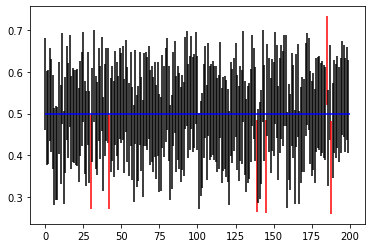

In [1111]:
plot_lims(lims, true_val)

### 2.5 Feldman-Cousins Intervals - upper and lower limits

In [1044]:
def toy(sig_hypo, scan_range = [-0.05, 0.05] ,n_evts=n):
    
    sig_weight = sig_hypo
    bkg_weight = 1. - sig_hypo
    
    # Generate dataset
    toy_data = sample_data(n_evts, weights=[sig_weight, bkg_weight])
    
    nll = lambda *args: -log_likelihood(*args)

    sig_frac_init = 0.
    params_init = np.array([sig_frac_init])
    mle_args = (toy_data)
    result = opt.minimize(nll, params_init, args=(mle_args), bounds=((-0.06, 0.25),))
    #print(result.x)
    mle = result.x[0]
    
    
    ll_mu = log_likelihood(sig_hypo, toy_data)
    
    if mle < 0.:
        #print(x_scan[x_min])
        ll_zero = log_likelihood(0., toy_data)
        return mle, -2*(ll_mu - ll_zero)
    else:
        ll_mle = log_likelihood(mle, toy_data)
        return mle, -2*(ll_mu - ll_mle)


In [1048]:
toys_mu_00 = np.array([toy(0.) for i in range(n_toys)])
toys_mu_01 = np.array([toy(0.1) for i in range(n_toys)])

In [1052]:
def plot_FC_toy(toys):
    chi_x = np.linspace(0.1,10,1000)
    chi_y = st.chi2(1).pdf(chi_x)
    plt.hist(toys[:,1], bins=50, density=True)
    plt.plot(chi_x, chi_y)
    plt.yscale('log')
    plt.show()

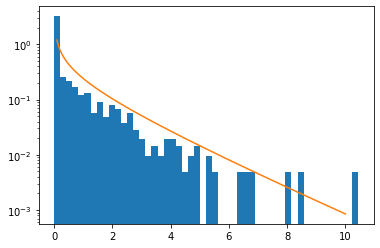

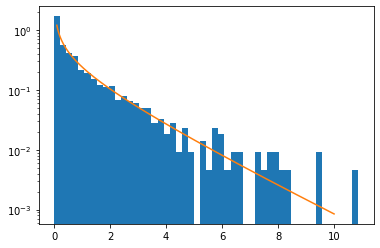

In [1053]:
plot_FC_toy(toys_mu_00)
plot_FC_toy(toys_mu_01)

In [1091]:
def belt(mu_up=0.1, npoints = 20, ntoys=5000):
    
    mu_vals = np.linspace(0., mu_up, npoints)
    lims = []
    for mu in mu_vals:
        #scan_range = [mu-0.2, mu+0.2]
        toys = np.array([toy(mu) for i in range(ntoys)])
        lim = np.percentile(toys[:,1], 95)/2
        lims.append(lim)
        print(mu, lim)
    return mu_vals, np.array(lims)

In [1092]:
mu_vals, lims = belt()

0.0 1.259647679472528
0.005263157894736842 1.19628350843985
0.010526315789473684 1.4020426873091618
0.015789473684210527 1.3609308383628766
0.021052631578947368 1.354373465554974
0.02631578947368421 1.4431703016589008
0.031578947368421054 1.5027894187727564
0.03684210526315789 1.6476589348247779


KeyboardInterrupt: 

In [1086]:
from scipy.interpolate import interp1d
f2 = interp1d(mu_vals, lims, kind='cubic')

In [1087]:
f2(0.04)

array(1.7184668)

In [1088]:
x = np.linspace(0.,0.1,100)

In [1089]:
f2(x)

array([1.26219036, 1.28101559, 1.29611695, 1.30782787, 1.31648174,
       1.32241197, 1.32595196, 1.32743511, 1.32719484, 1.32556455,
       1.32287763, 1.31946751, 1.31566757, 1.31181122, 1.30823188,
       1.30526294, 1.30323781, 1.30248989, 1.30335259, 1.30615931,
       1.31124345, 1.31893843, 1.32957765, 1.34337642, 1.3600777 ,
       1.37930639, 1.40068734, 1.42384545, 1.4484056 , 1.47399265,
       1.50023148, 1.52674699, 1.55316403, 1.5791075 , 1.60422654,
       1.62826742, 1.65100069, 1.67219687, 1.69162651, 1.70906015,
       1.72426833, 1.73702159, 1.74709048, 1.75424552, 1.75825726,
       1.75903008, 1.75700367, 1.75275158, 1.74684734, 1.73986448,
       1.73237654, 1.72495706, 1.71817957, 1.71261762, 1.70884473,
       1.70743444, 1.70882426, 1.71290756, 1.71944171, 1.72818404,
       1.73889192, 1.75132268, 1.76523368, 1.78038227, 1.7965258 ,
       1.81342162, 1.83082707, 1.84850645, 1.86625174, 1.88386186,
       1.90113574, 1.91787229, 1.93387045, 1.94892912, 1.96284

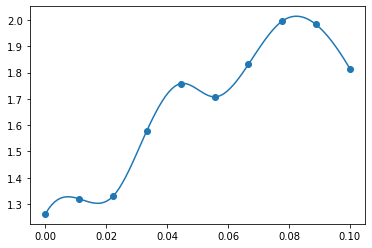

In [1090]:
plt.scatter(mu_vals, lims)
plt.plot(x, f2(x))

(0.0, 5.0)

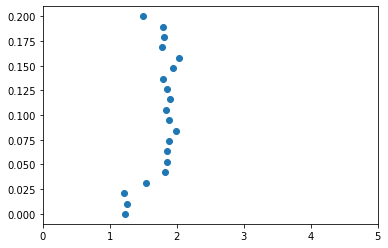

In [1055]:
plt.scatter(lims_2, mu_vals_2)
plt.xlim(0,5)

### 2.6 Nuisance parameters and Profile Likelihood

#### Unconditional ML estimate for one nuisance parameter 
In parameter estimation, the effect of NPs is incorporated through unconditional minimization, this means to minimize the Likelihood w.r.t all parameter simultaneously

In [334]:
def log_likelihood_nuisance(theta, x):

    sig_weight = theta[0]
    bkg_weight = 1 - sig_weight

    ll = st.norm(loc=theta[1], scale=norm_scale).pdf(x) * sig_weight + \
         st.expon(scale = exp_scale).pdf(x) * bkg_weight
    
    return np.log(ll).sum()

In [337]:
nll_nuis = lambda *args: -log_likelihood_nuisance(*args)

sig_frac_init, mean_init = 0.5, 2.5
params_init = np.array([sig_frac_init, mean_init])
mle_args = (data)
results_nuisance = opt.minimize(nll_nuis, params_init, args=(mle_args), bounds=((0., 1.),(None, None)))
print(results_nuisance)

      fun: 1062.7256205547235
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.05395577, 0.00234195])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 27
      nit: 7
   status: 0
  success: True
        x: array([0.06040762, 1.99128798])


In [349]:
mle_nuis = results_nuisance.x

In [339]:
def ll_nuisance_scan(x1_range=[0.,0.1], x2_range=[0.,5.], x1_points = 100, x2_points = 100):
    
    x1 = np.linspace(x1_range[0], x1_range[1], x1_points)
    x2 = np.linspace(x2_range[0], x2_range[1], x2_points)

    nll_val = np.zeros((len(x1), len(x2)))
    for i, x1_val in enumerate(x1):
        for j, x2_val in enumerate(x2):
            nll_val[i, j] = -1 * log_likelihood_nuisance([x1_val, x2_val], data)
    return nll_val

In [353]:
x1_range=[0.,0.2]
x2_range=[0.,5.]
x1_points = 100
x2_points = 100
nll_nuisance = ll_nuisance_scan(x1_range, x2_range, x1_points, x2_points)

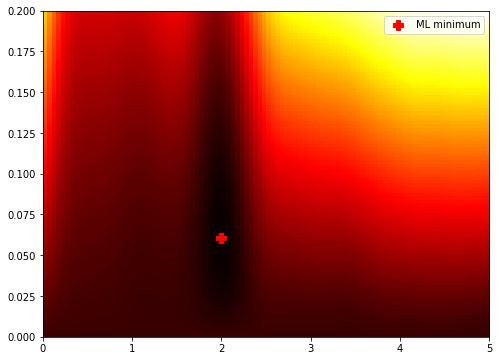

In [378]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
extent = [x2_range[0] , x2_range[1], x1_range[0], x1_range[1]]
plt.imshow(nll_nuisance, extent=extent, aspect='auto', origin='lower', cmap='hot')
plt.scatter(mle_nuis[1], mle_nuis[0], marker="P", s=100, c='r', label='ML minimum')
plt.legend(loc='upper right')

#### Unconditional ML estimate for one nuisance parameter with an auxiliary measurement
If >1 measurements exist that constrain (nuisance) parameters, one can combine information by formulating a joint likelihood: L(x,y|S,B)A+B = LA(x|S,B)*LB(y|B). No constraints shapes or forms of Likelihood
–  Can combine counting measurement, shape measurement
–  Likelihoods can have same observables, different observables, all OK
–  Only condition is that parameter have same meaning in all measurements. 
As an example we constrain the mean with a Gaussian measurement. If the nuisance deviates from its nomimal value it gets punished.

In [404]:
def ll_aux(mean, loc = norm_loc, scale = 0.1):

    mean_aux = st.norm(loc=loc, scale=scale).pdf(mean)
    return np.log(mean_aux)

In [405]:
def ll_extended(theta, data):
    
    ll = log_likelihood_nuisance(theta, data)
    aux = ll_aux(theta[1])
    return ll + aux

In [407]:
nll_extended = lambda *args: -ll_extended(*args)

sig_frac_init, mean_init = 0.5, 2.5
params_init = np.array([sig_frac_init, mean_init])
mle_args = (data)
results_nuisance = opt.minimize(nll_extended, params_init, args=(mle_args), bounds=((0., 1.),(None, None)))
print(results_nuisance)

      fun: 1061.3450802269117
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 8
   status: 0
  success: True
        x: array([0.06033229, 1.99286846])


####  NPs in hypothesis testing and confidence intervals - the profile likelihood
The goal in hypothesis testing and confidence intervals is that the parameter of interest should be covered at the stated confidence for every value of the nuisance parameters. This is technically very challenging and there are problems with over-coverage (-> Cox Weighting Procedure). Thus the LHC solution is conditioning on observed data by using the Profile Likelihood. 

In [1022]:
def ll_two_nuis(theta, x):
    
    sig_weight = theta[0]
    bkg_weight = 1 - sig_weight

    ll = st.norm(loc=theta[1], scale=norm_scale).pdf(x) * sig_weight + \
         st.expon(scale = theta[2]).pdf(x) * bkg_weight
    
    return np.log(ll).sum()
nll_two_nuis = lambda *args: -ll_two_nuis(*args)

In [792]:
sig_frac_init, mean_init, lambda_init = 0.1, 2.5, 1.1
params_init = np.array([sig_frac_init, mean_init, lambda_init])
mle_args = (data)
results_nuisance = opt.minimize(nll_two_nuis, params_init, args=(mle_args), bounds=((0., 1.),(1., 3.), (0.5, 1.5)))
print(results_nuisance)

      fun: 102.4824314760235
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.42108547e-06, 1.42108547e-05, 4.26325641e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 40
      nit: 7
   status: 0
  success: True
        x: array([0.09636552, 2.1608656 , 0.94411715])


In [1023]:
# Scan the negative log likelihood
def scan_nuis_nll(data, mle_min, x_range = [0.0,0.5], points = 1000):

    sig_frac_vals = np.linspace(x_range[0], x_range[1], points)
    nll_val = []
    for i, sig in enumerate(sig_frac_vals):
        nll_val.append( -1*ll_two_nuis([sig, mle_min[1], mle_min[2]], data) )
    return sig_frac_vals, np.array(nll_val)

x_scan, y_scan = scan_nuis_nll(data, results_nuisance.x, x_range = [0.0,0.5], points = 1000)

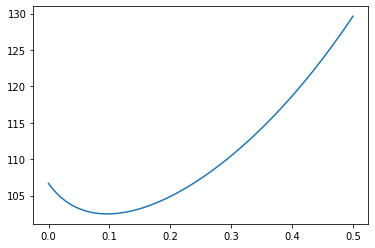

In [1024]:
plt.plot(x_scan, y_scan)

In [1038]:
def ll_conditional(theta, sig_frac, x):
    
    sig_weight = sig_frac
    bkg_weight = 1 - sig_weight

    ll = st.norm(loc=theta[0], scale=norm_scale).pdf(x) * sig_weight + \
         st.expon(scale = theta[1]).pdf(x) * bkg_weight
    
    return np.log(ll).sum()
    
nll_cond = lambda *args : - ll_conditional(*args)

def profile_likelihood(mu_range, n_points=100):
    mean_init, mean_lambda = 2.5, 1.1
    params_init = np.array([mean_init, mean_lambda])
    mu_vals = np.linspace(mu_range[0], mu_range[1], n_points)
    prof_nll = []
    for mu in mu_vals:
        mle_args = (mu, data)
        results_cond = opt.minimize(nll_cond, params_init, args=(mle_args))
        prof_nll.append(results_cond.fun)
    return mu_vals, np.array(prof_nll)

In [1039]:
mu_vals, prof_nll = profile_likelihood([0.0,0.2])

In [1040]:
mu_vals = mu_vals[~np.isnan(prof_nll)]
prof_nll = prof_nll[~np.isnan(prof_nll)]

ValueError: x and y must have same first dimension, but have shapes (10,) and (100,)

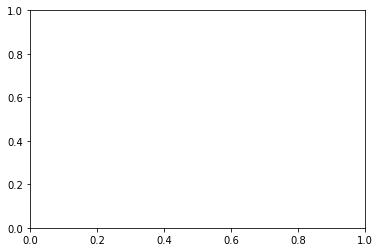

In [1130]:
plt.plot(mu_vals, prof_nll - prof_nll.min(), label='profiled nll')
plt.plot(x_scan, y_scan-y_scan.min(), label='nll')
plt.xlim(0., 0.2)
plt.ylim(0., 5.)
plt.legend(loc='upper right')
plt.show()

## 3. Bayesian analysis

### 3.1 Bayesian hypothesis testing

In case of two competing hypothesis, calculate $P(H_{s+b}|x) = \frac{L(x|H_{s+b})P(H_{s+b})}{L(x|H_{s+b})P(H_{s+b}) + L(x|H_{b})P(H_{b})}$

In [858]:
# Assume equal probabilities for Background and Signal+Background hypothesis
prior_b = 0.5
prior_sb = 0.5
b_hypo = 0.
sb_hypo = 0.1

ll_sb = np.exp(log_likelihood(sb_hypo, data) - mle_min)
ll_b = np.exp(log_likelihood(b_hypo, data) - mle_min)

p_sb = ll_sb * prior_sb / (ll_sb * prior_sb + ll_b * prior_b)
p_b = ll_b * prior_b / (ll_sb * prior_sb + ll_b * prior_b)

In [859]:
p_sb

0.9996427063343991

In [860]:
p_b

0.00035729366560101155

### 3.2 Parameter estimation by integration and MCMC

According to Bayes theorem, the posterior probability density is given by: $P(\mu | x ) = \frac{L(x|\mu)  P(\mu)}{\int L(x|\mu)  P(\mu) d\mu}$ with $L$ the likelihood and $P(\mu)$ the prior on the parameter $\mu$. The Bayesian parameter estimate is the posterior mean: $\hat{\mu} = \int \mu P(\mu|x) d\mu$ and the Bayesian variance is the posterior variance: $\hat{V} = \int (\mu - \hat{\mu})^2 P(\mu|x) d\mu$

In this simple problem we can obtain the prior by directly integrating the denominator of the Posterior.

#### Integration with uniform prior

In [1115]:
# First calculate the minimum of the likelihood - this will be useful in the following
nll = lambda *args: -log_likelihood(*args)
sig_frac_init = 0.5
params_init = np.array([sig_frac_init])
mle_args = (data)
results = opt.minimize(nll, params_init, args=(mle_args), bounds=((0., 1.),))
mle_min = results.fun

In [1116]:
# Define a uniform prior on the signal fraction
def log_prior(sig_frac):
    
    if (sig_frac < 0.) or (sig_frac > 1.):
        return -np.inf
    
    return np.log(st.uniform().pdf(sig_frac))

In [1117]:
# Integrate the evidence
def evidence(sig_frac, x=data):
    
    lp = log_prior(sig_frac)
    if not np.isfinite(lp):
        return -np.inf

    ll = log_likelihood(sig_frac, x)
    
    # Add the mle minimum to keep the exponent finite 
    return np.exp(ll + lp + mle_min )

from scipy.integrate import quad
evidence_integral, _ = quad(evidence, 0.0, 1.0, args=[data])

In [1128]:
#Posterior distribution
def posterior(sig_frac, x, evidence = evidence_integral):
    
    lp = log_prior(sig_frac)
    if not np.isfinite(lp):
        return -np.inf
    
    ll = log_likelihood(sig_frac, x)
    
    return np.exp(ll + lp + mle_min ) / evidence_integral

In [982]:
sig_fracs = np.linspace(0.,1.,1000)
post = []
prior = []
likelihood = []
for sig_frac in sig_fracs:
    post.append(posterior(sig_frac, data))
    prior.append(np.exp(log_prior(sig_frac)))
    likelihood.append(np.exp(log_likelihood(sig_frac, data) + mle_min))

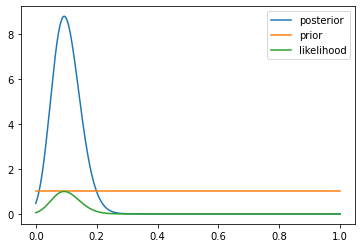

In [983]:
plt.plot(sig_fracs, post, label = 'posterior')
plt.plot(sig_fracs, prior, label = 'prior')
plt.plot(sig_fracs, likelihood, label = 'likelihood')
plt.legend(loc='upper right')

In [984]:
def mean_posterior(sig_frac, x=data):
    return sig_frac * posterior(sig_frac, x)
mean, _ = quad(mean_posterior, 0.0, 1.0)

def var_posterior(sig_frac, x=data):
    return (mean - sig_frac)**2 * posterior(sig_frac, x)
var, _ = quad(var_posterior, 0.0, 1.0)

In [985]:
print("Mean:", mean, "Var:", var)

Mean: 0.10199398862082497 Var: 0.0020306924098999436


#### MCMC with uniform prior

However, in general evaluating the posterior by integration is complicated and approximate methods ease the computation. A useful technique to obtain the posterior is using MCMC sampling:

In [108]:
# Install a lightweight MCMC sampler
!pip install emcee

In [852]:
def log_probability(sig_frac, x):

    lp = log_prior(sig_frac)
    if not np.isfinite(lp):
        return -np.inf

    ll = log_likelihood(sig_frac, x)

    return ll + lp

In [688]:
ndim = 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000 # number of MCMC steps to take

starting_guesses = results.x + 1e-4 * np.random.randn(50, ndim)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=[data])
sampler.run_mcmc(starting_guesses, nsteps, progress=True)
flat_samples = sampler.get_chain(discard=nburn, flat=True)

State([[0.04480571]
 [0.16962066]
 [0.13337589]
 [0.17044979]
 [0.1437382 ]
 [0.2765051 ]
 [0.15672491]
 [0.14149622]
 [0.21459915]
 [0.1585262 ]
 [0.14601303]
 [0.23280809]
 [0.24233425]
 [0.16336815]
 [0.16515485]
 [0.14811328]
 [0.14258117]
 [0.21169397]
 [0.24456027]
 [0.22378321]
 [0.17270064]
 [0.20728252]
 [0.13319055]
 [0.10830939]
 [0.15233144]
 [0.22254988]
 [0.19792041]
 [0.31119436]
 [0.14442824]
 [0.16844489]
 [0.16067612]
 [0.22195872]
 [0.11485947]
 [0.12322904]
 [0.29601589]
 [0.1883606 ]
 [0.20454937]
 [0.19583209]
 [0.1128033 ]
 [0.12681271]
 [0.18370999]
 [0.18425687]
 [0.16138665]
 [0.21555326]
 [0.13835547]
 [0.11914562]
 [0.14786845]
 [0.05524533]
 [0.19757518]
 [0.16229762]], log_prob=[-104.67728131 -100.60608906 -100.87686429 -100.60635307 -100.74033604
 -102.60042367 -100.6376429  -100.76564472 -100.98792497 -100.62912847
 -100.71698441 -101.33948848 -101.5652643  -100.61292133 -100.60936533
 -100.69748016 -100.75311083 -100.94183548 -101.62206034 -101.15189053

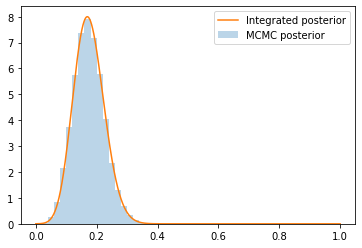

In [693]:
plt.hist(flat_samples, bins=50, range=[0,1], histtype="stepfilled", alpha=0.3, density=True, label='MCMC posterior')
plt.plot(sig_fracs, post, label='Integrated posterior')
plt.legend(loc='upper right')

In [748]:
print("Mean:", np.mean(flat_samples), "Var:", np.var(flat_samples))

Mean: 0.17406857314187052 Var: 0.002544659185279583


#### Test non-uniform prior

In [777]:
# Define a Gaussian prior on the signal fraction
def log_gaus_prior(sig_frac, loc=0.1, scale=0.05):
    
    if (sig_frac < 0.) or (sig_frac > 1.):
        return -np.inf
    
    return np.log(st.norm(loc=loc, scale=scale).pdf(sig_frac))

In [978]:
# Integrate the evidence
def evidence(sig_frac, x=data):
    
    lp = log_gaus_prior(sig_frac)
    if not np.isfinite(lp):
        return -np.inf

    ll = log_likelihood(sig_frac, x)
    
    # Add the mle minimum to keep the exponet 
    return np.exp(ll + lp + mle_min )

from scipy.integrate import quad
evidence_integral, _ = quad(evidence, 0.0, 1.0)

NameError: name 'log_gaus_prior' is not defined

In [843]:
#Posterior distribution
def posterior(sig_frac, x, evidence = evidence_integral):
    
    lp = log_gaus_prior(sig_frac)
    if not np.isfinite(lp):
        return -np.inf
    
    ll = log_likelihood(sig_frac, x)
    
    return np.exp(ll + lp + mle_min ) / evidence_integral

In [780]:
sig_fracs = np.linspace(0.,1.,1000)
post = []
prior = []
likelihood = []
for sig_frac in sig_fracs:
    post.append(posterior(sig_frac, data))
    prior.append(np.exp(log_gaus_prior(sig_frac)))
    likelihood.append(np.exp(log_likelihood(sig_frac, data) + mle_min))

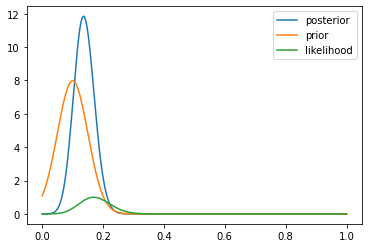

In [781]:
plt.plot(sig_fracs, post, label = 'posterior')
plt.plot(sig_fracs, prior, label = 'prior')
plt.plot(sig_fracs, likelihood, label = 'likelihood')
plt.legend(loc='upper right')

In [782]:
def mean_posterior(sig_frac, x=data):
    return sig_frac * posterior(sig_frac, x)
mean, _ = quad(mean_posterior, 0.0, 1.0)

def var_posterior(sig_frac, x=data):
    return (mean - sig_frac)**2 * posterior(sig_frac, x)
var, _ = quad(var_posterior, 0.0, 1.0)

print("Mean:", mean, "Var:", var)

Mean: 0.1379263370612693 Var: 0.0011265072163126253


### 3.3 Bayesian credible intervals

From the posterior density function, a credible interval can be constructed through integration.

In [987]:
# Approximate the cdf of the posterior obtained by integration:
def bayes_central_interval(sig_fracs, post, alpha = 0.05):
    
    lower_lim = alpha/2.
    upper_lim = 1 - alpha/2.

    cdf = 0.
    idx = 0
    while cdf < lower_lim:
        cdf += (post[idx] * (1/len(sig_fracs)))
        idx += 1
    lower = idx
    while cdf <= upper_lim:
        cdf += (post[idx] * (1/len(sig_fracs)))
        idx += 1
    #print(idx)
    upper = idx
    
    return sig_fracs[lower], sig_fracs[upper]

In [988]:
lower, upper = bayes_central_interval(sig_fracs, post, alpha = 0.05)

In [989]:
# Or use the MCMC 
mcmc_percentile = np.percentile(flat_samples, [2.5, 50, 100-2.5])

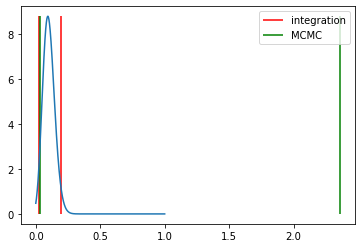

In [990]:
plt.plot(sig_fracs, post)
plt.vlines(lower, np.min(post), np.max(post), color='r', label='integration')
plt.vlines(upper, np.min(post), np.max(post), color='r')
plt.vlines(mcmc_percentile[0], np.min(post), np.max(post), color='g', label='MCMC')
plt.vlines(mcmc_percentile[2], np.min(post), np.max(post), color='g')
plt.legend(loc='upper right')

0


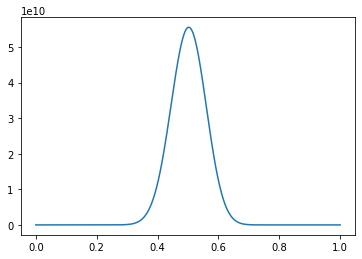

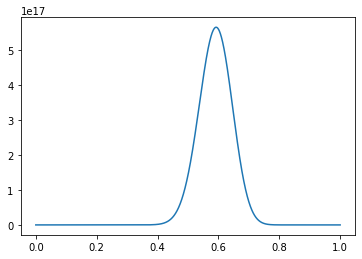

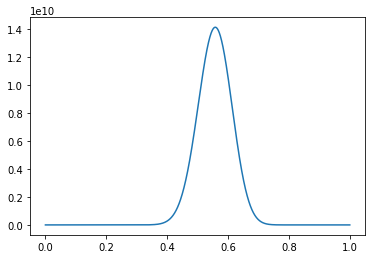

KeyboardInterrupt: 

In [1129]:
def test_coverage(true_val, n_toys, n_evts = n, xrange = [0.2,0.8], scan_points = 2000):
    
    lims = []
    for i in range(n_toys):

        if i%10 == 0:
            print(i)
        toy_data = sample_data(n_evts, weights = [true_val,1-true_val])
        toy_evidence, _ = quad(evidence, 0.0, 1.0, args=[toy_data])
        x_vals = np.linspace(0., 1., scan_points)
        toy_post = [posterior(x, toy_data, toy_evidence) for x in x_vals]
        plt.plot(x_vals, toy_post)
        plt.show()
        lower_toy, upper_toy = bayes_central_interval(x_vals, toy_post)
        lims.append([lower_toy, upper_toy])
    return lims

true_val = 0.5
lims_bayes = test_coverage(0.5, 200)

In [1120]:
lims = []
for i in range(100):

    if i%10 == 0:
        print(i)
    toy_data = sample_data(n)
    # Integrate the evidence
    
    toy_evidence, _ = quad(evidence, 0.0, 1.0, args=[toy_data])
    print(toy_evidence)
    x_vals = np.linspace(0., 1., 5000)
    toy_post = [posterior(x, toy_data, toy_evidence) for x in x_vals]
    lower_toy, upper_toy = bayes_central_interval(x_vals, toy_post)
    lims.append([lower_toy, upper_toy])

0
3.377156667411914
0.009324107243721728


IndexError: list index out of range

### 3.4 Jeffrey's prior

In [864]:
import autograd
import autograd.numpy as autonp

In [868]:
def nll_auto(sig_frac, x=data):

    sig_weight = sig_frac
    bkg_weight = 1 - sig_weight

    ll = st.norm(norm_loc, norm_scale).pdf(x) * sig_weight + st.expon(scale = exp_scale).pdf(x) * bkg_weight

    return -1*autonp.log(ll).sum()

In [872]:
jacobian = autograd.jacobian(nll_auto)
hessian = autograd.hessian(nll_auto)

In [897]:
def get_derivatives(xrange=[0.,0.9], xpoints=1000):
    
    x_vals = np.linspace(xrange[0], xrange[1], xpoints)
    nll = np.array([nll_auto(x) for x in x_vals ])
    jac = np.array([autonp.array([jacobian(x)]) for x in x_vals ])
    hess = np.array([autonp.array([hessian(x)]) for x in x_vals ])

    return x_vals, nll, np.squeeze(jac), np.squeeze(hess)

In [898]:
xauto_vals, nll_vals, jac_vals, hess_vals = get_derivatives()

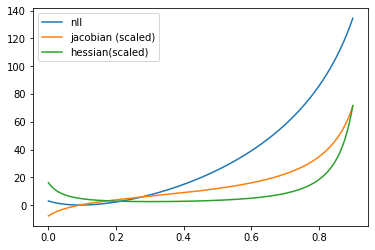

In [899]:
plt.plot(xauto_vals, nll_vals - nll_vals.min(), label='nll')
plt.plot(xauto_vals, jac_vals*0.1, label='jacobian (scaled)')
plt.plot(xauto_vals, hess_vals*0.01, label='hessian(scaled)')
plt.legend(loc='upper left')

In [900]:
def jeffrey(theta):
    return autonp.sqrt(autonp.array([hessian(theta)]))

from scipy.integrate import quad
jeff_integ, _ = quad(jeffrey, 0.0, 0.9)

In [960]:
def jeffrey_prior(theta):
    
    if (theta < 0.) or (theta > 0.9):
        return 0.
    return autonp.sqrt(autonp.array([hessian(theta)]))[0] / jeff_integ

In [941]:
jeffrey_prob = np.array([jeffrey_prior(x) for x in xauto_vals[1:-2]])

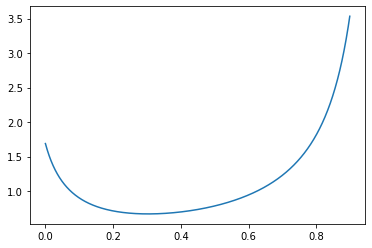

In [970]:
plt.plot(xauto_vals[1:-2], jeffrey_prob)

In [961]:
# Integrate the evidence
def evidence_jeffrey(theta, x=data):

    ll =  np.exp(log_likelihood(theta, x)+mle_min)
    jp = jeffrey_prior(theta)
    return ll * jp

In [962]:
evidence_jeffrey(0.1)

0.8934505609309945

In [963]:
from scipy.integrate import quad
evidence_integral, _ = quad(evidence_jeffrey, 0.0, 0.9)

In [964]:
evidence_integral

0.10691339233036612

In [965]:
def posterior_jeffrey(theta, x=data):
    
    ll =  np.exp(log_likelihood(theta, x)+mle_min)
    jp = jeffrey_prior(theta)
    return (ll * jp) / evidence_integral

In [966]:
post_jeffrey = [posterior_jeffrey(x, data) for x in xauto_vals[1:-2]]

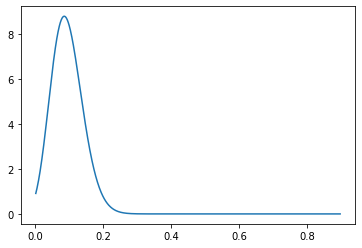

In [967]:
plt.plot(xauto_vals[1:-2], post_jeffrey)

In [968]:
def mean_posterior(theta, x=data):
    return theta * posterior_jeffrey(theta, x)
mean, _ = quad(mean_posterior, 0.0, 0.9)

def var_posterior(theta, x=data):
    return (mean - theta)**2 * posterior_jeffrey(theta, x)
var, _ = quad(var_posterior, 0.0, 0.9)

In [969]:
mean, var

(0.09442843478160408, 0.0020190128432778045)

### 3.5. Dealing with nuisance parameters

In [850]:
def log_priors(theta):
    
    if (theta[0] <=0.) or (theta[0] >= 1.):
        return -np.inf
    if (theta[1] <=1.) or (theta[1] >= 3.):
        return -np.inf
    if (theta[2] <=0.5) or (theta[2] >= 1.5):
        return -np.inf
    
    prior0 = st.uniform().pdf(theta[0])
    prior1 = st.uniform(loc=1.,scale=2.).pdf(theta[1])
    prior2 = st.uniform(loc=0.5,scale=1.).pdf(theta[2])
    return np.log(prior0) + np.log(prior1) + np.log(prior2)

In [851]:
def log_prob_nuis(theta, x):
    lp = log_priors(theta)
    if not np.isfinite(lp):
        return -np.inf

    ll = ll_two_nuis(theta, x)

    return ll + lp 

In [971]:
ndim = 3  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000 # number of MCMC steps to take

starting_guesses = results_nuisance.x + 1e-4 * np.random.randn(nwalkers, ndim)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_nuis, args=[data])
sampler.run_mcmc(starting_guesses, nsteps, progress=True)
flat_samples = sampler.get_chain(discard=nburn, flat=True)

100%|██████████| 2000/2000 [23:38<00:00,  1.41it/s]  


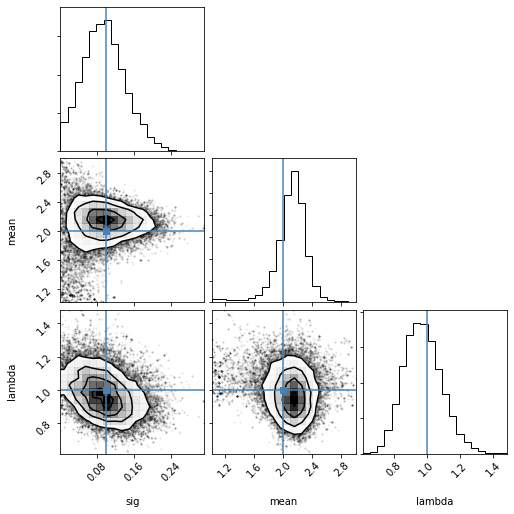

In [972]:
import corner
fig = corner.corner(flat_samples, labels=['sig', 'mean', 'lambda'], truths=[0.1,2, 1.])

In [862]:
sig_interval = np.percentile(flat_samples[:,0], [2.5, 50, 100-2.5])
mean_interval = np.percentile(flat_samples[:,1], [2.5, 50, 100-2.5])
lambda_interval = np.percentile(flat_samples[:,2], [2.5, 50, 100-2.5])
#q = np.diff(mcmc)

In [863]:
sig_interval, mean_interval, lambda_interval

(array([0.01227007, 0.09106314, 0.19091189]),
 array([1.59246272, 2.13632917, 2.50841173]),
 array([0.77887371, 0.97484192, 1.22772862]))

## Likelihood principle

In Bayesian methods and likelihood-ratio based methods, the probability (density) for obtaining the data at hand is used (via the likelihood function), but probabilities for obtaining other data are not used! In contrast, in typical frequentist calculations (e.g., a p-value which is the probability of obtaining a value as extreme or more extreme than that observed), one uses probabilities of data not seen. This difference is captured by the Likelihood Principle:
If two experiments yield likelihood functions which are proportional, then Your inferences from the two experiments should be identical.